# NLP classifier using training and testing data

In [1]:
import pandas as pd
import re
import joblib
import matplotlib as plt

In [2]:
df = pd.read_csv('/Users/vidhiparmar/Desktop/projects/spending_tracker_prediction/data/final_transactions.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes

Date              datetime64[ns]
Description               object
Amount                   float64
NewDescription            object
Type                      object
dtype: object

In [3]:
# manually categorizing the data for training and testing using regex

def categorize(description):
    if re.search(r"(shoppers|rexall|pharmacy|drug)", description):
        return "Pharmacy"
    elif re.search(r"(starbucks|timhortons|coffee|cafe|tea|matcha|ippodo|espressobar|espresso|varda|dean|arabica|caf|tsujiri|milkys|alley)", description):
        return "Cafe"
    elif re.search(r"(walmart|loblaws|nofrills|grocery|metro|johndanielles|market|hmart|fortinos|subzimandi|7 eleven|convenience|eleven)", description):
        return "Groceries"
    elif re.search(r"(ubercanadatoronto|lyft|ubertrip|taxi|presto|shell|petro)", description):
        return "Transport"
    elif re.search(r"(netflix|spotify|subscription|disneyplus|bill|insurance|virginplus)", description):
        return "Subscription"
    elif re.search(r"(payment|credit|thankyou|cashback|interest)", description):
        return "Credit Card Payment"
    elif re.search(r"(restaurant|dining|pizza|mcdonalds|burger|waffle|eats|chicken|kellyslanding|dairyqueen|bakery|bistro|popeyes|chatime|chipotle|brewhouse|mexicana|kitc|sweets|craveables|baskinrobbins|ice|hakkalicious|villacaledon|kfc|shanghai|turtlejacks|beavertails|food|earls|krispykreme|tacos|blueclaw|pizz|eataly|bagel|gelateria|ramen|demetres|wingstop|waffles|shakeshack|bhc|cocacola|restaur)", description):
        return "Food & Dining"
    elif re.search(r"(dollarama|shein|hudsonsbay|yorkdale|amzn|shop|bodyworks|zara|thrift|valuevillage|kiokii|uniqlo|arden|ikea|apple|dollarstore)", description):
        return "Shopping"
    elif re.search(r"(newnham|campus|onecard)", description):
        return "Campus Cafeteria"
    else:
        return "Other"


## Feature Engineering

In [5]:
df['Month'] = df['Date'].dt.strftime('%b')
df['Year'] = df['Date'].dt.year
df['Category'] = df['NewDescription'].apply(categorize)
df = df[['Date', 'Month', 'Year', 'Description', 'NewDescription', 'Amount', 'Type', 'Category']]

### 1. TF-IDF vectorizer 

In [6]:
# tf-idf vectorizer
# converting text into features

from sklearn.feature_extraction.text import TfidfVectorizer

# TfidfVectorizer converts your text to numerical values.
vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=2,
                             sublinear_tf=True)
X_tf = vectorizer.fit_transform(df['NewDescription'])

In [7]:
# training the classifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf, df['Category'], test_size=0.2)

model_tf = LogisticRegression()
#model = LogisticRegression(class_weight='balanced')

model_tf.fit(X_tf_train, y_tf_train)

from sklearn.metrics import classification_report, accuracy_score

y_tf_pred = model_tf.predict(X_tf_test)
print(classification_report(y_tf_test, y_tf_pred))


                     precision    recall  f1-score   support

               Cafe       1.00      0.78      0.88        23
   Campus Cafeteria       1.00      1.00      1.00        24
Credit Card Payment       1.00      1.00      1.00         3
      Food & Dining       0.41      1.00      0.58        21
          Groceries       1.00      0.89      0.94         9
              Other       0.00      0.00      0.00         5
           Pharmacy       1.00      0.33      0.50         3
           Shopping       1.00      0.17      0.29         6
       Subscription       1.00      0.50      0.67         2
          Transport       1.00      0.08      0.15        12

           accuracy                           0.72       108
          macro avg       0.84      0.58      0.60       108
       weighted avg       0.84      0.72      0.69       108



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

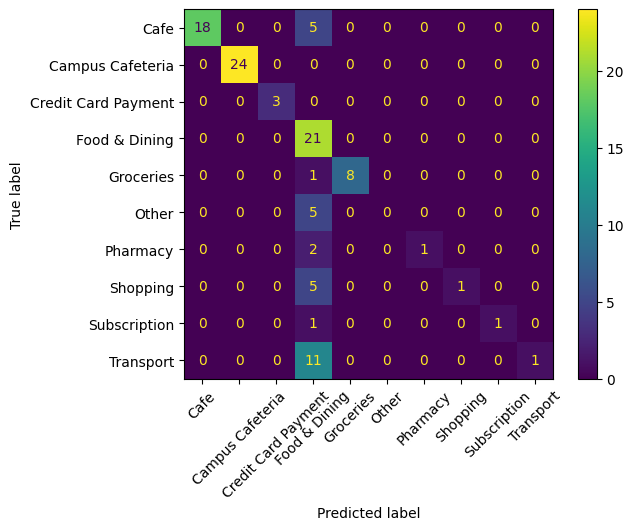

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model_tf, X_tf_test, y_tf_test, xticks_rotation=45)


### 2. BERT sentence vectorizer 

In [9]:
# BERT sentence vectorizer
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
X_b = model.encode(df['NewDescription'])


In [10]:
# training the classifier

X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X_b, df['Category'], test_size=0.2)

model_b = LogisticRegression(class_weight= 'balanced')

model_b.fit(X_b_train, y_b_train)

from sklearn.metrics import classification_report, accuracy_score

y_b_pred = model_b.predict(X_b_test)
print(classification_report(y_b_test, y_b_pred))


                     precision    recall  f1-score   support

               Cafe       0.86      0.90      0.88        20
   Campus Cafeteria       1.00      1.00      1.00        14
Credit Card Payment       1.00      1.00      1.00         5
      Food & Dining       0.95      0.78      0.86        27
          Groceries       0.86      0.67      0.75         9
              Other       0.00      0.00      0.00         2
           Pharmacy       1.00      1.00      1.00         2
           Shopping       0.50      0.80      0.62         5
       Subscription       0.67      1.00      0.80         4
          Transport       1.00      1.00      1.00        20

           accuracy                           0.87       108
          macro avg       0.78      0.81      0.79       108
       weighted avg       0.90      0.87      0.88       108



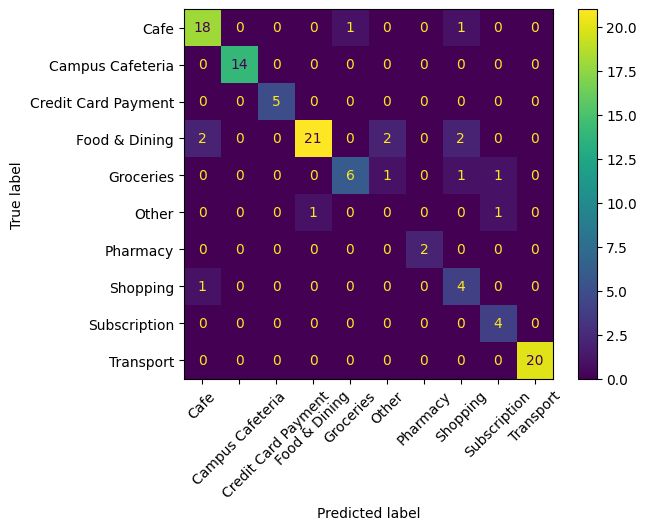

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model_b, X_b_test, y_b_test, xticks_rotation=45)


In [12]:
joblib.dump(model_b, 'logistic_bert_classifier.pkl')


['logistic_bert_classifier.pkl']

In [13]:
def clean_description(desc):
    desc = desc.lower()
    desc = re.sub(r'[^a-z]', '', desc)
    return desc

In [14]:
df2 = pd.read_csv('sample_transactions.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2['Month'] = df2['Date'].dt.strftime('%b')
df2['Year'] = df2['Date'].dt.year
df['NewDescription'] = df['Description'].apply(clean_description)


In [15]:
monthly = df2.groupby(['Year', 'Month'])['Amount'].sum().reset_index()
